In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:85% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

**<font size="6" color="red">ch4. RNN(Recurrent Neural Network 순환신경망)</font>**
# 1. 문맥을 이용하여 모델만들기

In [2]:
text = """경마장에 있는 말이 뛰고 있다 
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다"""
# text1 = "장마철이 오고 있다"

In [3]:
# from keras_preprocessing.text import Tokenizer
# t = Tokenizer()
# t.fit_on_texts([text, text1])
# encoded = t.texts_to_sequences([text, text1])
# print(encoded)
# print(t.word_index)

In [4]:
from keras_preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts([text])
encoded = t.texts_to_sequences([text])
print(encoded)
print(t.word_index)

[[2, 3, 1, 4, 5, 6, 1, 7, 8, 1, 9, 10, 1, 11]]
{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [5]:
# 문자열 리스트를 인덱스 시퀀스로 변환
print(t.texts_to_sequences(['경마장에 말이 있다','말이 뛴다']))
print(t.texts_to_sequences(['가는 말이 곱다'])[0])

[[2, 1, 5], [1]]
[8, 1, 11]


In [6]:
text = """경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다"""

In [7]:
for key, value in t.word_index.items():
    print(key, value)

말이 1
경마장에 2
있는 3
뛰고 4
있다 5
그의 6
법이다 7
가는 8
고와야 9
오는 10
곱다 11


In [8]:
# 학습을 시키기 위해 ['경마장에 있는','경마장에 있는 말이', ...]
sequences = []
for line in text.split('\n'):
    print('원문장 :', line)
    encoded = t.texts_to_sequences([line])[0]
    print('encoded된 문장 :', encoded)
    for i in range(0, len(encoded)-1): # i:시작index
        for j in range(i+2, len(encoded)+1): # j:끝나는 index바로 뒤
            sequences.append(encoded[i:j])
# print(sequences)
print('sequences와 해석 출력')
for sequence in sequences:
    for word_seq in sequence:
        for word, id in t.word_index.items():
            if word_seq==id:
                print("{}:{}".format(word_seq, word), end=' ')
                break
    print()

원문장 : 경마장에 있는 말이 뛰고 있다
encoded된 문장 : [2, 3, 1, 4, 5]
원문장 : 그의 말이 법이다
encoded된 문장 : [6, 1, 7]
원문장 : 가는 말이 고와야 오는 말이 곱다
encoded된 문장 : [8, 1, 9, 10, 1, 11]
sequences와 해석 출력
2:경마장에 3:있는 
2:경마장에 3:있는 1:말이 
2:경마장에 3:있는 1:말이 4:뛰고 
2:경마장에 3:있는 1:말이 4:뛰고 5:있다 
3:있는 1:말이 
3:있는 1:말이 4:뛰고 
3:있는 1:말이 4:뛰고 5:있다 
1:말이 4:뛰고 
1:말이 4:뛰고 5:있다 
4:뛰고 5:있다 
6:그의 1:말이 
6:그의 1:말이 7:법이다 
1:말이 7:법이다 
8:가는 1:말이 
8:가는 1:말이 9:고와야 
8:가는 1:말이 9:고와야 10:오는 
8:가는 1:말이 9:고와야 10:오는 1:말이 
8:가는 1:말이 9:고와야 10:오는 1:말이 11:곱다 
1:말이 9:고와야 
1:말이 9:고와야 10:오는 
1:말이 9:고와야 10:오는 1:말이 
1:말이 9:고와야 10:오는 1:말이 11:곱다 
9:고와야 10:오는 
9:고와야 10:오는 1:말이 
9:고와야 10:오는 1:말이 11:곱다 
10:오는 1:말이 
10:오는 1:말이 11:곱다 
1:말이 11:곱다 


In [9]:
print([len(sequence) for sequence in sequences])
my_len = max(len(sequence) for sequence in sequences)
my_len

[2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 2, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2]


6

In [10]:
# sequences를 훈련 가능하도록 모두 6개로 조정
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(sequences=sequences,
                                maxlen=my_len,
                                # padding='post',
                                padding='pre')
padded_sequences.shape, type(padded_sequences)
#padded_sequences

((28, 6), numpy.ndarray)

In [11]:
# 독립변수(X)와 타겟변수(y)로 분리
X = padded_sequences[:, :-1]
y = padded_sequences[:, -1]
y

array([ 3,  1,  4,  5,  1,  4,  5,  4,  5,  5,  1,  7,  7,  1,  9, 10,  1,
       11,  9, 10,  1, 11, 10,  1, 11,  1, 11, 11])

In [12]:
# X를 엠베딩 작업할 때 필요한 입력 bit 수 (단어수+1) 
input_dim = len(t.word_index)+1
input_dim

12

In [13]:
# y의 원핫인코딩
from tensorflow.keras.utils import to_categorical
Y = to_categorical(y, input_dim)
X.shape, Y.shape, input_dim

((28, 5), (28, 12), 12)

In [14]:
# 2. 모델 생성하기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding # Xi의 원핫인코딩한 희소행렬 변환
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

model = Sequential()
model.add(Embedding(input_dim=input_dim,  # 12개로 원핫인코딩
                   output_dim=10, # 임베딩 출력의 갯수
                   input_length=X.shape[1])) # 입력(X)의 수
model.add(SimpleRNN(units=32))
model.add(Dense(12, activation='softmax'))
print(model.summary())
# 3. 모델 학습 과정 설정
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
# 4. 모델 학습시키기
hist = model.fit(X, Y, epochs=300, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 10)             120       
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1376      
                                                                 
 dense (Dense)               (None, 12)                396       
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
1/1 - 1s - loss: 2.4834 - accuracy: 0.0714 - 787ms/epoch - 787ms/step
Epoch 2/300
1/1 - 0s - loss: 2.4725 - accuracy: 0.1071 - 3ms/epoch - 3ms/step
Epoch 3/300
1/1 - 0s - loss: 2.4615 - accuracy: 0.1071 - 2ms/epoch - 2ms/step
Epoch 4/300
1/1 - 0s - loss: 2.4504 - accuracy: 0.1429 - 0s/epoch - 0s/step

Epoch 96/300
1/1 - 0s - loss: 1.3837 - accuracy: 0.6429 - 5ms/epoch - 5ms/step
Epoch 97/300
1/1 - 0s - loss: 1.3671 - accuracy: 0.6429 - 4ms/epoch - 4ms/step
Epoch 98/300
1/1 - 0s - loss: 1.3505 - accuracy: 0.6429 - 5ms/epoch - 5ms/step
Epoch 99/300
1/1 - 0s - loss: 1.3338 - accuracy: 0.6429 - 3ms/epoch - 3ms/step
Epoch 100/300
1/1 - 0s - loss: 1.3171 - accuracy: 0.6786 - 4ms/epoch - 4ms/step
Epoch 101/300
1/1 - 0s - loss: 1.3004 - accuracy: 0.6786 - 6ms/epoch - 6ms/step
Epoch 102/300
1/1 - 0s - loss: 1.2838 - accuracy: 0.6786 - 5ms/epoch - 5ms/step
Epoch 103/300
1/1 - 0s - loss: 1.2672 - accuracy: 0.6786 - 7ms/epoch - 7ms/step
Epoch 104/300
1/1 - 0s - loss: 1.2507 - accuracy: 0.6786 - 4ms/epoch - 4ms/step
Epoch 105/300
1/1 - 0s - loss: 1.2344 - accuracy: 0.6786 - 5ms/epoch - 5ms/step
Epoch 106/300
1/1 - 0s - loss: 1.2182 - accuracy: 0.6786 - 4ms/epoch - 4ms/step
Epoch 107/300
1/1 - 0s - loss: 1.2021 - accuracy: 0.7143 - 3ms/epoch - 3ms/step
Epoch 108/300
1/1 - 0s - loss: 1.1863 - accu

Epoch 200/300
1/1 - 0s - loss: 0.4856 - accuracy: 0.8571 - 3ms/epoch - 3ms/step
Epoch 201/300
1/1 - 0s - loss: 0.4823 - accuracy: 0.8571 - 0s/epoch - 0s/step
Epoch 202/300
1/1 - 0s - loss: 0.4790 - accuracy: 0.8571 - 1ms/epoch - 1ms/step
Epoch 203/300
1/1 - 0s - loss: 0.4758 - accuracy: 0.8929 - 0s/epoch - 0s/step
Epoch 204/300
1/1 - 0s - loss: 0.4726 - accuracy: 0.8929 - 12ms/epoch - 12ms/step
Epoch 205/300
1/1 - 0s - loss: 0.4695 - accuracy: 0.8929 - 311us/epoch - 311us/step
Epoch 206/300
1/1 - 0s - loss: 0.4664 - accuracy: 0.8929 - 0s/epoch - 0s/step
Epoch 207/300
1/1 - 0s - loss: 0.4633 - accuracy: 0.8929 - 0s/epoch - 0s/step
Epoch 208/300
1/1 - 0s - loss: 0.4602 - accuracy: 0.8929 - 15ms/epoch - 15ms/step
Epoch 209/300
1/1 - 0s - loss: 0.4572 - accuracy: 0.8929 - 0s/epoch - 0s/step
Epoch 210/300
1/1 - 0s - loss: 0.4543 - accuracy: 0.8929 - 0s/epoch - 0s/step
Epoch 211/300
1/1 - 0s - loss: 0.4513 - accuracy: 0.8929 - 0s/epoch - 0s/step
Epoch 212/300
1/1 - 0s - loss: 0.4484 - accura

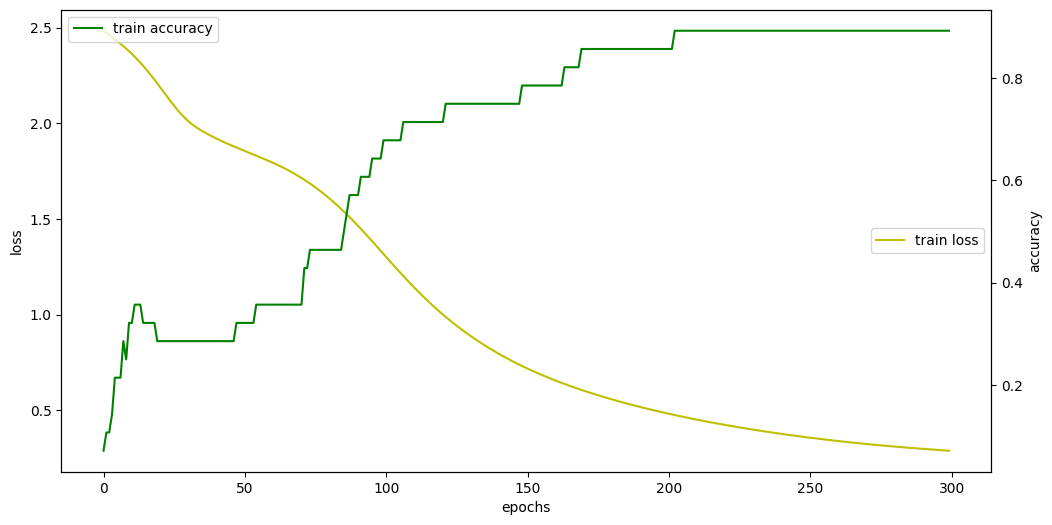

In [15]:
# 5. 모델 학습과정 시각화
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(loc='upper left')
plt.show()

In [33]:
# 모델 사용하기 (경마장에 있는 말이 -> 뛰고)
input_word = input('입력단어 :')
encoded = t.texts_to_sequences([input_word])[0]
input_data = pad_sequences([encoded], maxlen=my_len-1, padding='pre')
print('입력데이터 :', input_data)
result = model.predict(input_data, verbose=0).argmax()
word = t.index_word[result]
print('예측된 단어 :', word)

입력단어 :가는 말이
입력데이터 : [[0 0 0 8 1]]
예측된 단어 : 고와야


In [30]:
t.texts_to_sequences(['없는 단어'])

[[]]

# 2. 다음 문맥 예측해 보기

In [43]:
# "경마장에" 이후에 올 단어 3개 예측 -> 경마장에 있는 말이 뛰고
def sentence_generation(current_word, n):
    # print('입력된 단어 :', current_word)
    for i in range(1, n+1):
        encoded = t.texts_to_sequences([current_word])[0]
        input_data = pad_sequences([encoded], maxlen=my_len-1, padding='pre')
        result = model.predict(input_data, verbose=0).argmax()
        word = t.index_word[result]
        current_word = current_word + ' ' + word
#         print("{}번째 생성 문맥 {} ({}{})".format(i,
#                                            current_word,
#                                            encoded,
#                                            result) )
    return current_word
sentence_generation('경마장에', 3)

'경마장에 있는 말이 뛰고'

In [44]:
sentence_generation('가는', 5)

'가는 말이 고와야 오는 말이 곱다'